# Goal

In this notebook, we seek to find "hedging" bigrams by using the word2vec embeddings for unigrams that are part of hedging bigrams. Examples include:  

* "Sort" coming from "sort of"
* "kind" coming from "kind of"
* "Guess" used in "I guess"

Following the ideas from Ben Schmidt's [Rejecting the gender binary: a vector-space operation](http://bookworm.benschmidt.org/posts/2015-10-30-rejecting-the-gender-binary.html), we will build a vector for the collection of "hedging" unigrams and then use "vector rejection" to remove non-hedging uses of the hedging unigrams. For example: 

* "Sort" coming from "sort of" but not "arrange, list, classify" nor "variety, category, type"
* "kind" coming from "kind of" but not "friendly, nice, patience" nor "variety, category, type"
* "Guess" used in "I guess" but not "predict, determine, explain" 

 Look here: https://stackabuse.com/implementing-word2vec-with-gensim-library-in-python/
 
 https://medium.com/swlh/word-embedding-word2vec-with-genism-nltk-and-t-sne-visualization-43eae8ab3e2e


In [57]:
import numpy as np
import pandas as pd, re, csv, nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
import nltk
from nltk.corpus import stopwords

# https://stackoverflow.com/questions/37101114/what-to-download-in-order-to-make-nltk-tokenize-word-tokenize-work
#nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

from gensim.models import Word2Vec

# for preprocessing the text
from gensim.parsing.preprocessing import remove_stopwords
import string


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Creating a stopword list of consonants and the 

stoplist = list(string.ascii_letters[:26])
stoplist.pop(8) # Remove 'i'
stoplist.pop(0) # Remove 'a'

stoplist.append("ll")
stoplist.append("re")
stoplist.append("ve")


In [3]:
# Building my own stopword remover to get rid of the non "a" and "i" consonants
# Based on `remove_stopewords() in gensim
#    https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/parsing/preprocessing.py

def remove_stoplist(s):
    return " ".join(remove_stoplist_tokens(s.split()))

def remove_stoplist_tokens(tokens):
    global stoplist
    return [token for token in tokens if token not in stoplist]

In [4]:
# Load data

# Load binary gendered talks 
talks_male = pd.read_csv('talks_male.csv', index_col='Talk_ID')
talks_female = pd.read_csv('talks_female.csv', index_col='Talk_ID')

# No one gender ==> NOG
talks_nog = pd.read_csv('talks_nog.csv', index_col='Talk_ID')

# Concatenate the data

all_talks = pd.concat([talks_male,talks_female,talks_nog])

In [5]:
partitioned_texts = all_talks.text.tolist()

# From https://www.geeksforgeeks.org/python-string-join-method/
#text_all = " ".join(partitioned_texts)

processed_texts = [text.lower() for text in partitioned_texts]
processed_texts = [re.sub('[^a-zA-Z]', ' ', text) for text in processed_texts]
processed_texts = [re.sub(r'\s+', ' ', text) for text in processed_texts]


In [6]:
partitioned_texts[0][:50]

"  Thank you so much, Chris. And it's truly a great"

In [7]:
processed_texts = [remove_stoplist(text) for text in processed_texts]
doc_texts = [nltk.word_tokenize(text) for text in processed_texts]

In [10]:
type(doc_texts)

list

In [11]:
len(doc_texts)

992

In [13]:
len(doc_texts[0])

2135

### Count Vectorizer

Doing unigram counts for hedging:


In [8]:
unigram_vectorizer = CountVectorizer(lowercase = True, 
                             min_df = 2,
                             max_df = 0.9,
                             ngram_range=(1, 1))

uX = unigram_vectorizer.fit_transform(processed_texts)

In [11]:
uX.shape

(992, 21982)

### Word2Vec for Unigrams

In [14]:
word2vec = Word2Vec(doc_texts, window = 10, min_count=2)

In [15]:
word2vec.wv.most_similar("guess")

[('remember', 0.7878257036209106),
 ('saying', 0.7463921308517456),
 ('mean', 0.7254163026809692),
 ('hear', 0.7243103384971619),
 ('say', 0.7161790728569031),
 ('freaks', 0.6847013235092163),
 ('wondering', 0.6838622689247131),
 ('wow', 0.6759593486785889),
 ('gosh', 0.6710530519485474),
 ('stroking', 0.666327178478241)]

In [16]:
word2vec.wv.most_similar("sort")

[('kind', 0.9084411859512329),
 ('bunch', 0.6164745688438416),
 ('part', 0.607398509979248),
 ('piece', 0.606497049331665),
 ('type', 0.5873291492462158),
 ('palpable', 0.5767520070075989),
 ('course', 0.5679629445075989),
 ('sculpting', 0.5670973658561707),
 ('pieces', 0.5498916506767273),
 ('juxtaposition', 0.5496965050697327)]

In [17]:
word2vec.wv.most_similar("kind")

[('sort', 0.9084411859512329),
 ('type', 0.6930367350578308),
 ('sense', 0.6429963111877441),
 ('part', 0.6213728189468384),
 ('idea', 0.6002641320228577),
 ('sculpting', 0.5995984077453613),
 ('view', 0.5885249376296997),
 ('course', 0.5702580213546753),
 ('piece', 0.5698479413986206),
 ('translations', 0.5509598851203918)]

In [27]:
# https://stackoverflow.com/questions/65612062/how-do-i-subtract-and-add-vectors-with-gensim-keyedvectors

word2vec.wv.most_similar(["sort"])

[('kind', 0.9084411859512329),
 ('bunch', 0.6164745688438416),
 ('part', 0.607398509979248),
 ('piece', 0.606497049331665),
 ('type', 0.5873291492462158),
 ('palpable', 0.5767520070075989),
 ('course', 0.5679629445075989),
 ('sculpting', 0.5670973658561707),
 ('pieces', 0.5498916506767273),
 ('juxtaposition', 0.5496965050697327)]

In [28]:
word2vec.wv.most_similar(["kind"])

[('sort', 0.9084411859512329),
 ('type', 0.6930367350578308),
 ('sense', 0.6429963111877441),
 ('part', 0.6213728189468384),
 ('idea', 0.6002641320228577),
 ('sculpting', 0.5995984077453613),
 ('view', 0.5885249376296997),
 ('course', 0.5702580213546753),
 ('piece', 0.5698479413986206),
 ('translations', 0.5509598851203918)]

In [37]:
word2vec.wv.most_similar(["sort", "kind"])

[('type', 0.65535968542099),
 ('part', 0.628950834274292),
 ('piece', 0.6021162271499634),
 ('sculpting', 0.597177267074585),
 ('bunch', 0.5917701125144958),
 ('course', 0.582602322101593),
 ('view', 0.5773004293441772),
 ('sense', 0.5725947618484497),
 ('translations', 0.5549792647361755),
 ('idea', 0.5518763661384583)]

In [38]:
word2vec.wv.most_similar(["sort", "guess"])

[('kind', 0.713141918182373),
 ('thought', 0.6781673431396484),
 ('mean', 0.6316622495651245),
 ('picture', 0.6002448201179504),
 ('crazy', 0.5881516933441162),
 ('suppose', 0.5881208777427673),
 ('thinking', 0.5835904479026794),
 ('weird', 0.5798344016075134),
 ('freaks', 0.5760444402694702),
 ('wow', 0.5706294775009155)]

In [36]:
word2vec.wv.most_similar(["kind","guess"])

[('mean', 0.7195830345153809),
 ('sort', 0.6939854621887207),
 ('thought', 0.6852900981903076),
 ('think', 0.6535386443138123),
 ('suppose', 0.6083480715751648),
 ('feeling', 0.6066697835922241),
 ('saying', 0.6019819974899292),
 ('say', 0.6017744541168213),
 ('thinking', 0.5997294783592224),
 ('hear', 0.594313383102417)]

In [31]:
word2vec.wv.most_similar(["sort", "kind","guess"])

[('thought', 0.6158742904663086),
 ('piece', 0.5884854793548584),
 ('audit', 0.5860133171081543),
 ('picture', 0.5853383541107178),
 ('stuff', 0.5837016105651855),
 ('thinking', 0.5804150104522705),
 ('part', 0.5796677470207214),
 ('mean', 0.5717465281486511),
 ('weird', 0.5683267116546631),
 ('illustration', 0.5653871297836304)]

In [35]:
negative_list = ["type","variety", "category",
                 "friendly", "nice", "patience",
                 "predict", "determine", "explain", 
                 "arrange", "list", "classify"]

word2vec.wv.most_similar(["sort", "kind","guess"], negative = negative_list)

[('learnings', 0.49738916754722595),
 ('jolla', 0.42620810866355896),
 ('kanwisher', 0.39031463861465454),
 ('gaulle', 0.3745385408401489),
 ('depressants', 0.3686690032482147),
 ('inundated', 0.3616965413093567),
 ('tithers', 0.3391382694244385),
 ('jell', 0.33261242508888245),
 ('stocked', 0.3267320990562439),
 ('nigerians', 0.31234732270240784)]

In [48]:
# From below, it looks like "I guess" is not in the TED talks:
negative_list = ["type","variety", "category",
                 "friendly", "nice", "patience",
                 "arrange", "list", "classify"]

word2vec.wv.most_similar(["sort", "kind"], negative = negative_list)

[('learnings', 0.4751196503639221),
 ('electrophysiology', 0.35263317823410034),
 ('jolla', 0.3518185019493103),
 ('gaulle', 0.3486708402633667),
 ('divulge', 0.3439455032348633),
 ('nigerians', 0.3119773864746094),
 ('fortuitous', 0.31005990505218506),
 ('heartening', 0.3018244206905365),
 ('gasped', 0.2899802327156067),
 ('depressants', 0.2886291742324829)]

In [49]:
word2vec.wv.most_similar(["sort", "kind"], negative = ["type"])

[('blackboards', 0.5507946014404297),
 ('course', 0.5351001024246216),
 ('stuff', 0.5219084620475769),
 ('part', 0.4799818694591522),
 ('bunch', 0.478828489780426),
 ('palpable', 0.4682005047798157),
 ('thought', 0.46191030740737915),
 ('crazy', 0.4439011812210083),
 ('mangle', 0.43668049573898315),
 ('grill', 0.4359477758407593)]

## Bigrams

https://stackoverflow.com/questions/19560044/how-to-concatenate-element-wise-two-lists-in-python
https://www.w3schools.com/python/ref_string_format.asp

### CountVectorizer



In [12]:
bigram_vectorizer = CountVectorizer(lowercase = True, 
                             min_df = 2,
                             max_df = 0.9,
                             ngram_range=(2, 2))

bX = bigram_vectorizer.fit_transform(processed_texts)

In [13]:
bX.shape

(992, 140985)

In [32]:
raw_bX = pd.DataFrame(bX.toarray(), 
                      columns = bigram_vectorizer.get_feature_names_out())
raw_bX.shape

(992, 140985)

In [33]:
bigram_list = list(raw_bX.columns)

In [37]:
so = bigram_list.index("sort of")

In [41]:
max(bX.toarray()[:,so])

17

In [43]:
sum(bX.toarray()[:,so]>0)

324

In [29]:
bigram_list[so-5:so+6]

['sorry to',
 'sorry we',
 'sorry what',
 'sorry you',
 'sort and',
 'sort of',
 'sort or',
 'sort out',
 'sort the',
 'sort this',
 'sort you']

In [24]:
bigram_list.index("I guess")


ValueError: 'I guess' is not in list

In [30]:
ko = bigram_list.index("kind of")

In [31]:
bigram_list[ko-5:ko+6]

['kind attention',
 'kind but',
 'kind enough',
 'kind in',
 'kind it',
 'kind of',
 'kind or',
 'kind so',
 'kind thank',
 'kind that',
 'kind the']

In [42]:
max(bX.toarray()[:,ko])

30

In [44]:
sum(bX.toarray()[:,ko]>0)

595

Do "kind of" and "sort of" show up in the same talks? 

In [45]:
bX_array = bX.toarray()

sum((bX_array[:,so] + bX_array[:,ko]) == 2)

111

In [46]:
inds = (bX_array[:,so] + bX_array[:,ko]) > 1

In [60]:
hedgers = bX_array[inds,:]


In [61]:
c_inds = [ko,so]
hedgers = hedgers[:,c_inds]



In [91]:
mu = 0
std = 0.05

noisy_hedgers = hedgers + np.random.normal(mu,std,(487,2))

In [55]:
hedgers.shape

(487, 2)

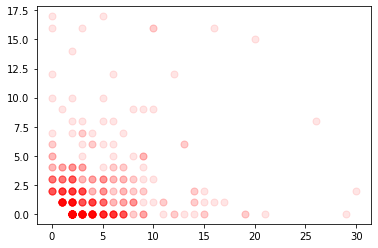

In [82]:
plt.scatter(hedgers[:,0],hedgers[:,1],s = 50, alpha=0.1, c = 'r')

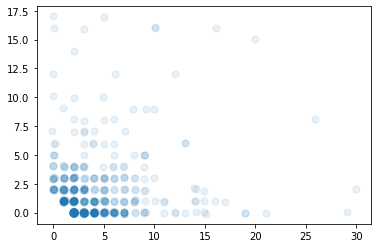

In [92]:
plt.scatter(noisy_hedgers[:,0],noisy_hedgers[:,1], s = 50, alpha=0.1)

In [39]:
doc_bigrams = []

for text_list in doc_texts[:100]:
    # Create two lists from the original text list
    # The first includes the 0 -> (n-1) words
    # The second includes the 1 -> n words
    l_text = text_list[:-1]
    r_text = text_list[1:]
    
    # Use zip and format with list comprehension to get a new list
    bi_list = ["{} {}".format(l_word,r_word) for l_word,r_word in zip(l_text,r_text)]
    
    doc_bigrams.append(bi_list)

In [40]:
type(doc_bigrams)

list

In [41]:
len(doc_bigrams)

100

In [42]:
doc_bigrams[0]

['thank you',
 'you so',
 'so much',
 'much chris',
 'chris and',
 'and it',
 'it truly',
 'truly a',
 'a great',
 'great honor',
 'honor to',
 'to have',
 'have the',
 'the opportunity',
 'opportunity to',
 'to come',
 'come to',
 'to this',
 'this stage',
 'stage twice',
 'twice i',
 'i extremely',
 'extremely grateful',
 'grateful i',
 'i have',
 'have been',
 'been blown',
 'blown away',
 'away by',
 'by this',
 'this conference',
 'conference and',
 'and i',
 'i want',
 'want to',
 'to thank',
 'thank all',
 'all of',
 'of you',
 'you for',
 'for the',
 'the many',
 'many nice',
 'nice comments',
 'comments about',
 'about what',
 'what i',
 'i had',
 'had to',
 'to say',
 'say the',
 'the other',
 'other night',
 'night and',
 'and i',
 'i say',
 'say that',
 'that sincerely',
 'sincerely partly',
 'partly because',
 'because mock',
 'mock sob',
 'sob i',
 'i need',
 'need that',
 'that laughter',
 'laughter put',
 'put yourselves',
 'yourselves in',
 'in my',
 'my position',
 'p

In [43]:
bigram2vec = Word2Vec(doc_bigrams, min_count=5, window = 20)

### 20 talks, default window
bigram2vec.wv.most_similar("kind of")

`[('is the', 0.9678242802619934),
 ('of the', 0.9669575691223145),
 ('it s', 0.9658999443054199),
 ('in the', 0.9641684889793396),
 ('and i', 0.9638648629188538),
 ('on the', 0.9616329669952393),
 ('and the', 0.9615666270256042),
 ('if you', 0.9613533616065979),
 ('you can', 0.9594166874885559),
 ('to do', 0.959026575088501)]`

### 100 talks, default window
bigram2vec.wv.most_similar("kind of")

`[('on the', 0.9999475479125977),
 ('of a', 0.9999454021453857),
 ('sort of', 0.9999436736106873),
 ('and the', 0.9999433755874634),
 ('into the', 0.9999430179595947),
 ('and he', 0.9999375343322754),
 ('it the', 0.9999349117279053),
 ('on a', 0.9999347925186157),
 ('from the', 0.9999346733093262),
 ('in this', 0.9999346733093262)]`

### 100 talks, window = 20
bigram2vec.wv.most_similar("kind of")

`[('of a', 0.9999916553497314),
 ('into the', 0.999990701675415),
 ('it a', 0.9999901056289673),
 ('on the', 0.9999899864196777),
 ('on a', 0.9999896287918091),
 ('it the', 0.9999895691871643),
 ('sort of', 0.99998939037323),
 ('like this', 0.9999883770942688),
 ('and a', 0.9999881982803345),
 ('to a', 0.9999878406524658)]`

### 100 talks, window = 20, min = 5
bigram2vec.wv.most_similar("kind of")

`[('on a', 0.9999414682388306),
 ('sort of', 0.9999383687973022),
 ('into the', 0.9999372959136963),
 ('in a', 0.9999362230300903),
 ('it the', 0.9999334812164307),
 ('it a', 0.9999327659606934),
 ('to a', 0.9999301433563232),
 ('so it', 0.9999282360076904),
 ('and a', 0.9999277591705322),
 ('like a', 0.9999269247055054)]`

In [44]:
bigram2vec.wv.most_similar("kind of")

[('it a', 0.9999397397041321),
 ('into the', 0.9999394416809082),
 ('as a', 0.9999366998672485),
 ('of this', 0.9999359846115112),
 ('it the', 0.9999359846115112),
 ('in a', 0.9999358654022217),
 ('sort of', 0.9999354481697083),
 ('a very', 0.9999338388442993),
 ('on a', 0.9999335408210754),
 ('like a', 0.9999316930770874)]

In [46]:
bigram2vec.wv.most_similar("sort of")

[('out of', 0.999960720539093),
 ('of this', 0.9999575018882751),
 ('of that', 0.999955415725708),
 ('in a', 0.9999552965164185),
 ('to a', 0.9999551773071289),
 ('as a', 0.9999541640281677),
 ('into the', 0.999953031539917),
 ('a year', 0.9999524354934692),
 ('on a', 0.9999517798423767),
 ('of course', 0.9999503493309021)]

In [47]:
bigram2vec.wv.most_similar("I guess")

KeyError: "word 'I guess' not in vocabulary"

# Scratch work below here

## WANT: a list of lists 

 * Each text should be preserved 
 * Then we should create a list of words

In [45]:
test = ['one',"Two\'s",'.ThreE']
#test = partitioned_texts[0:3]
print(len(test))
#https://www.delftstack.com/howto/python/python-lowercase-list/

test = [word.lower() for word in test]
print(len(test))
test = [re.sub('[^a-zA-Z]', ' ', word) for word in test]
print(len(test))
test= [re.sub(r'\s+', ' ', word) for word in test]
print(len(test))


3
3
3
3


In [76]:
test

['one', 'two s', ' three']

In [80]:
remove_stoplist('two s and')

'two and'

In [81]:
test_texts = [remove_stoplist(text) for text in test]

In [82]:
test_texts

['one', 'two', 'three']

In [83]:
test_texts = [remove_stoplist(text) for text in test]

test_texts = [nltk.word_tokenize(text) for text in test_texts]

In [84]:
test_texts

[['one'], ['two'], ['three']]

In [ ]:
constants = 

In [53]:
all_letters = string.ascii_letters

In [58]:
stops = list(all_letters[:26])

In [61]:
stops.pop(8)

AttributeError: 'str' object has no attribute 'pop'

In [62]:
stops.pop(0)

'a'

In [63]:
stops

['b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [ ]:
test_texts = 

In [ ]:
processed_texts = [text.lower() for text in partitioned_texts]
processed_texts = [re.sub('[^a-zA-Z]', ' ', text) for text in processed_texts]
processed_texts = [re.sub(r'\s+', ' ', text) for text in processed_texts]

In [19]:
test1 = test_sub[:-1]
test2 = test_sub[1:]

In [23]:
test1
test2

test3 = []
for inds in range(len(test1)):
    bigram = test1[inds] + " " + test2[inds]
    test3.append(bigram)

In [24]:
test3


['one twos', 'twos three']

In [29]:
["{} {}".format(l_word,r_word) for l_word,r_word in zip(test1,test2)]

['one twos', 'twos three']

In [28]:
for l_word,r_word in zip(test1,test2):
    print(r_word)

twos
three


In [11]:
processed_texts = text_all.lower()
processed_texts = re.sub('[^a-zA-Z]', ' ', processed_texts)
processed_texts = re.sub(r'\s+', ' ', processed_texts)

In [12]:
processed_texts[:50]

' thank you so much chris and it s truly a great ho'

In [10]:
# From https://stackabuse.com/implementing-word2vec-with-gensim-library-in-python/

all_sentences = nltk.sent_tokenize(processed_texts)

all_words = [nltk.word_tokenize(sent) for sent in all_sentences]

In [11]:
type(all_sentences)

list

In [21]:
len(all_sentences[0])

10699443

In [26]:
word2vec = Word2Vec(all_words, min_count=2)

NameError: name 'Word2Vec' is not defined